In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

### Motor Control
We'll start with simulated [PI](https://en.wikipedia.org/wiki/PID_controller) control of a DC Motor, and view a step response

In [2]:
def pwm_control(w_desired,w_measured,Kp,Ki,e_sum):
    
    duty_cycle = min(max(0,Kp*(w_desired-w_measured) + Ki*e_sum),1)
    e_sum = e_sum + w_desired-w_measured
    
    return duty_cycle, e_sum

In [3]:
def motor_simulator(w,duty_cycle):

    I = 5
    dt = 0.1
    d = 1
    
    torque = I*duty_cycle

    if (w > 0):
        w = min(w + dt*(torque - d*w),3)
    elif (w < 0):
        w = max(w + dt*(torque - d*w),-3)
    else:
        w = w + dt*(torque)

    return w

Try playing with the controller gains to see how this affects the response

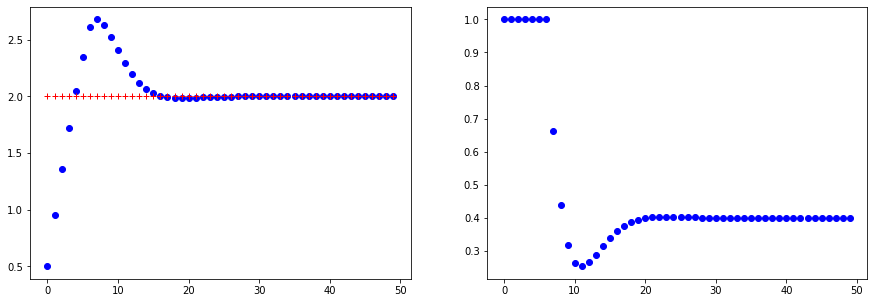

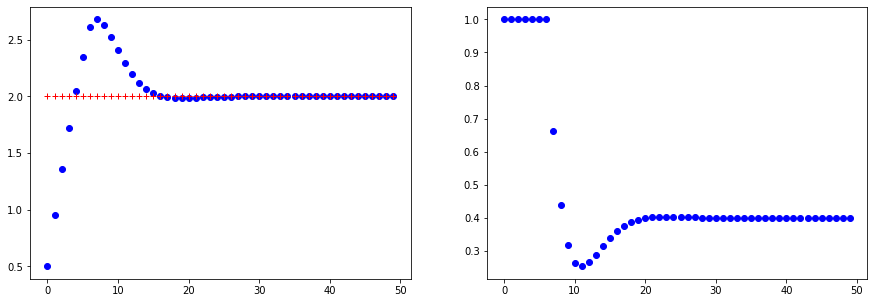

In [4]:
w = 0
w_desired = 2.0
w_measured = 0.0
duty_cycle = 0

plt.figure(figsize=(15,5))
e_sum = 0

for j in range(50):
    
    
    duty_cycle,e_sum = pwm_control(w_desired,w_measured,Kp=1.0,Ki=0.25,e_sum=e_sum)
    
    w_measured = motor_simulator(w_measured,duty_cycle)
    
    plt.subplot(1,2,1)
    plt.plot(j,w_measured,'bo')
    plt.plot(j,w_desired,'r+')
    
    plt.subplot(1,2,2)
    plt.plot(j,duty_cycle,'bo')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    

### Differential drive robot model
Now we'll put two motors together, and simulate a differential drive robot. We'll use some of the motion models and derivations in [this paper](https://doi.org/10.1109/ICRA.2012.6224684). This motion model can be used to estimate the position of our robot given the commands we send to it.

In [5]:
class DiffDriveRobot:
    
    def __init__(self,inertia=5, dt=0.1, drag=0.2, wheel_radius=0.05, wheel_sep=0.15):
        
        self.x = 0.0 # y-position
        self.y = 0.0 # y-position 
        self.th = 0.0 # orientation
        
        self.wl = 0.0 #rotational velocity left wheel
        self.wr = 0.0 #rotational velocity right wheel
        
        self.I = inertia
        self.d = drag
        self.dt = dt
        
        self.r = wheel_radius
        self.l = wheel_sep
    
    # Should be replaced by motor encoder measurement which measures how fast wheel is turning
    # Here, we simulate the real system and measurement
    def motor_simulator(self,w,duty_cycle):
        
        torque = self.I*duty_cycle
        
        if (w > 0):
            w = min(w + self.dt*(torque - self.d*w),3)
        elif (w < 0):
            w = max(w + self.dt*(torque - self.d*w),-3)
        else:
            w = w + self.dt*(torque)
        
        return w
    
    # Veclocity motion model
    def base_velocity(self,wl,wr):
        
        v = (wl*self.r + wr*self.r)/2.0
        
        w = (wl - wr)/self.l
        
        return v, w
    
    # Kinematic motion model
    def pose_update(self,duty_cycle_l,duty_cycle_r):
        
        self.wl = self.motor_simulator(self.wl,duty_cycle_l)
        self.wr = self.motor_simulator(self.wr,duty_cycle_r)
        
        v, w = self.base_velocity(self.wl,self.wr)
        
        self.x = self.x + self.dt*v*np.cos(self.th)
        self.y = self.y + self.dt*v*np.sin(self.th)
        self.th = self.th + w*self.dt
        
        return self.x, self.y, self.th
        

### Kinematic motion control
Let's use the PI motor controller to control the forward and rotational velocity of our robot.

In [6]:
class RobotController:
    
    def __init__(self,Kp=0.1,Ki=0.01,wheel_radius=0.02, wheel_sep=0.1):
        
        self.Kp = Kp
        self.Ki = Ki
        self.r = wheel_radius
        self.l = wheel_sep
        self.e_sum_l = 0
        self.e_sum_r = 0
        
    def p_control(self,w_desired,w_measured,e_sum):
        
        duty_cycle = min(max(-1,self.Kp*(w_desired-w_measured) + self.Ki*e_sum),1)
        
        e_sum = e_sum + (w_desired-w_measured)
        
        return duty_cycle, e_sum
        
        
    def drive(self,v_desired,w_desired,wl,wr):
        
        wl_desired = v_desired/self.r + self.l*w_desired/2 
        wr_desired = v_desired/self.r - self.l*w_desired/2
        
        duty_cycle_l,self.e_sum_l = self.p_control(wl_desired,wl,self.e_sum_l)
        duty_cycle_r,self.e_sum_r = self.p_control(wr_desired,wr,self.e_sum_r)
        
        return duty_cycle_l, duty_cycle_r
        

In [7]:
robot = DiffDriveRobot(inertia=5, dt=0.1, drag=1, wheel_radius=0.05, wheel_sep=0.15)
controller = RobotController(Kp=1,Ki=0.25,wheel_radius=0.05,wheel_sep=0.15)

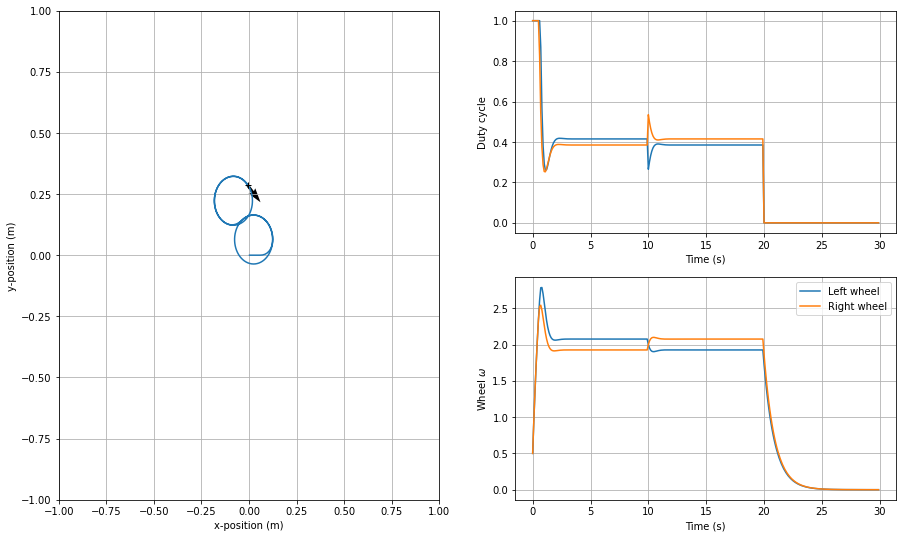

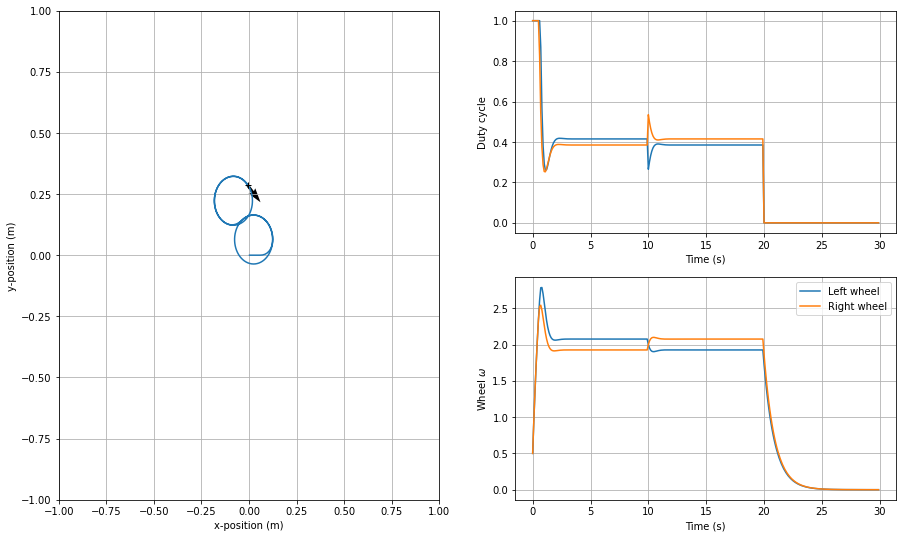

In [8]:
plt.figure(figsize=(15,9))

poses = []
velocities = []
duty_cycle_commands = []
for i in range(300):

    # Example motion using controller 
    
    if i < 100: # drive in circular path (turn left) for 10 s
        duty_cycle_l,duty_cycle_r = controller.drive(0.1,1,robot.wl,robot.wr)
    elif i < 200: # drive in circular path (turn right) for 10 s
        duty_cycle_l,duty_cycle_r = controller.drive(0.1,-1,robot.wl,robot.wr)
    else: # stop
        duty_cycle_l,duty_cycle_r = (0,0)
    
    # Simulate robot motion - send duty cycle command to robot
    x,y,th = robot.pose_update(duty_cycle_l,duty_cycle_r)
    
    # Log data
    poses.append([x,y,th])
    duty_cycle_commands.append([duty_cycle_l,duty_cycle_r])
    velocities.append([robot.wl,robot.wr])
    
    # Plot robot data
    plt.clf()
    plt.cla()
    plt.subplot(1,2,1)
    plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
    plt.plot(x,y,'k',marker='+')
    plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel('x-position (m)')
    plt.ylabel('y-position (m)')
    plt.grid()
    
    plt.subplot(2,2,2)
    plt.plot(np.arange(i+1)*robot.dt,np.array(duty_cycle_commands))
    plt.xlabel('Time (s)')
    plt.ylabel('Duty cycle')
    plt.grid()
    
    plt.subplot(2,2,4)
    plt.plot(np.arange(i+1)*robot.dt,np.array(velocities))
    plt.xlabel('Time (s)')
    plt.ylabel('Wheel $\omega$')
    plt.legend(['Left wheel', 'Right wheel'])
    plt.grid()
    
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    

### Driving with tentacles
Ok, now let's put together an algorithm to control our robot to move towards goals. We'll use a simplified version of a strategy called [dynamic window rollout](https://doi.org/10.1109/ROBOT.2007.363613), or [driving with tentacles](https://doi.org/10.1002/rob.20256). This is a type of model predictive control, which is commonly used in chemical and industrial manufacturing plants.

In [9]:
class TentaclePlanner:
    
    def __init__(self,dt=0.1,steps=5,alpha=1,beta=0.1):
        
        self.dt = dt
        self.steps = steps
        # Tentacles are possible trajectories to follow
        self.tentacles = [(0.0,0.5),(0.0,-0.5),(0.1,1.0),(0.1,-1.0),(0.1,0.5),(0.1,-0.5),(0.1,0.0),(0.0,0.0)]
        
        self.alpha = alpha
        self.beta = beta
    
    # Play a trajectory and evaluate where you'd end up
    def roll_out(self,v,w,goal_x,goal_y,goal_th,x,y,th):
        
        for j in range(self.steps):
        
            x = x + self.dt*v*np.cos(th)
            y = y + self.dt*v*np.sin(th)
            th = (th + w*self.dt)
        
        e_th = goal_th-th
        e_th = np.arctan2(np.sin(e_th),np.cos(e_th))
        
        return self.alpha*((goal_x-x)**2 + (goal_y-y)**2) + self.beta*(e_th**2)
    
    # Choose trajectory that will get you closest to the goal
    def plan(self,goal_x,goal_y,goal_th,x,y,th):
        
        costs =[]
        for v,w in self.tentacles:
            costs.append(self.roll_out(v,w,goal_x,goal_y,goal_th,x,y,th))
        
        best_idx = np.argmin(costs)
        
        return self.tentacles[best_idx]
        

In [10]:
robot = DiffDriveRobot(inertia=10, dt=0.1, drag=2, wheel_radius=0.05, wheel_sep=0.15)
controller = RobotController(Kp=1.0,Ki=0.15,wheel_radius=0.05,wheel_sep=0.15)
planner = TentaclePlanner(dt=0.1,steps=5,alpha=1,beta=1e-5)

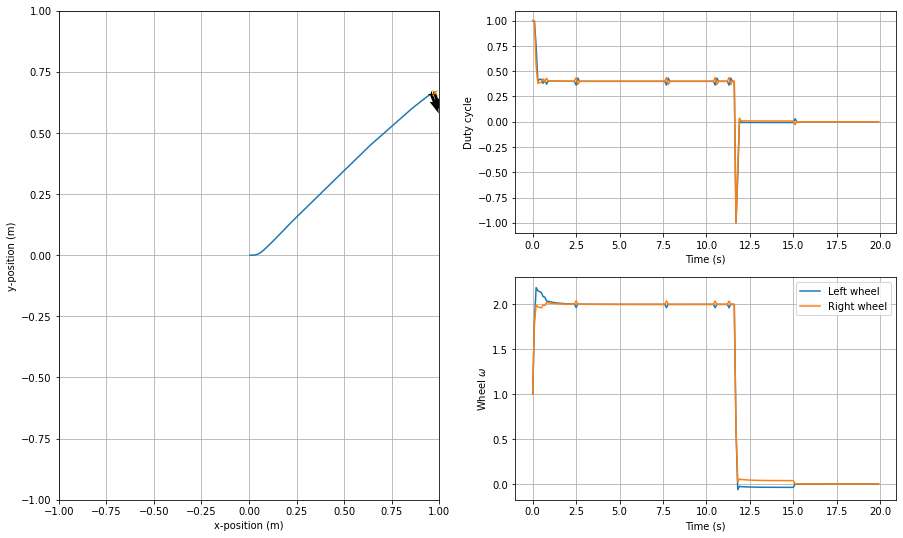

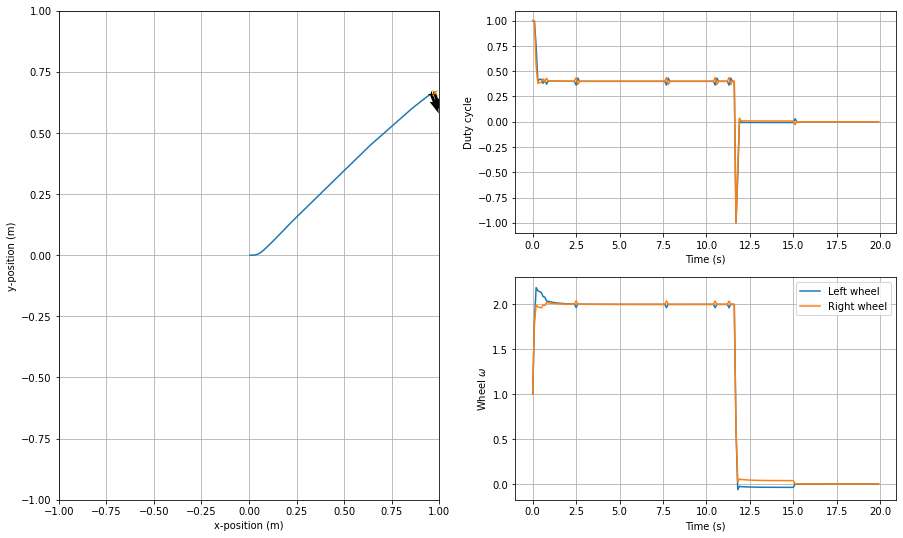

In [11]:
plt.figure(figsize=(15,9))

poses = []
velocities = []
duty_cycle_commands = []

goal_x = 2*np.random.rand()-1
goal_y = 2*np.random.rand()-1
goal_th = 2*np.pi*np.random.rand()-np.pi

for i in range(200):

    # Plan using tentacles
    v,w = planner.plan(goal_x,goal_y,goal_th,robot.x,robot.y,robot.th)
    
    duty_cycle_l,duty_cycle_r = controller.drive(v,w,robot.wl,robot.wr)
    
    # Simulate robot motion - send duty cycle command to robot
    x,y,th = robot.pose_update(duty_cycle_l,duty_cycle_r)
    
    # Log data
    poses.append([x,y,th])
    duty_cycle_commands.append([duty_cycle_l,duty_cycle_r])
    velocities.append([robot.wl,robot.wr])
    
    # Plot robot data
    plt.clf()
    plt.subplot(1,2,1)
    plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
    plt.plot(x,y,'k',marker='+')
    plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
    plt.plot(goal_x,goal_y,'x',markersize=5)
    plt.quiver(goal_x,goal_y,0.1*np.cos(goal_th),0.1*np.sin(goal_th))
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel('x-position (m)')
    plt.ylabel('y-position (m)')
    plt.grid()
    
    plt.subplot(2,2,2)
    plt.plot(np.arange(i+1)*robot.dt,np.array(duty_cycle_commands))
    plt.xlabel('Time (s)')
    plt.ylabel('Duty cycle')
    plt.grid()
    
    plt.subplot(2,2,4)
    plt.plot(np.arange(i+1)*robot.dt,np.array(velocities))
    plt.xlabel('Time (s)')
    plt.ylabel('Wheel $\omega$')
    plt.legend(['Left wheel', 'Right wheel'])
    plt.grid()
    
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    

### Obstacle avoidance 

Now, let's modify our tentacle planner to avoid obstacles (assuming we know where they are). You can use a similar strategy with the ultrasound detector. If an object is detected on the left, ignore tentacles turning left when computing the cost. If an object is detected on the right, ignore tentacles turning right when computing the cost. 

In [12]:
class TentaclePlanner:
    
    def __init__(self,obstacles,dt=0.1,steps=5,alpha=1,beta=0.1):
        
        self.dt = dt
        self.steps = steps
        # Tentacles are possible trajectories to follow
        self.tentacles = [(0.0,1.0),(0.0,-1.0),(0.1,1.0),(0.1,-1.0),(0.1,0.5),(0.1,-0.5),(0.1,0.0),(0.0,0.0)]
        
        self.alpha = alpha
        self.beta = beta
        
        self.obstacles = obstacles
    
    # Play a trajectory and evaluate where you'd end up
    def roll_out(self,v,w,goal_x,goal_y,goal_th,x,y,th):
        
        for j in range(self.steps):
        
            x = x + self.dt*v*np.cos(th)
            y = y + self.dt*v*np.sin(th)
            th = (th + w*self.dt)
            
            if (self.check_collision(x,y)):
                return np.inf
        
        # Wrap angle error -pi,pi
        e_th = goal_th-th
        e_th = np.arctan2(np.sin(e_th),np.cos(e_th))
        
        cost = self.alpha*((goal_x-x)**2 + (goal_y-y)**2) + self.beta*(e_th**2)
        
        return cost
    
    def check_collision(self,x,y):
        
        min_dist = np.min(np.sqrt((x-self.obstacles[:,0])**2+(y-self.obstacles[:,1])**2))
        
        if (min_dist < 0.1):
            return True
        return False
        
    
    # Choose trajectory that will get you closest to the goal
    def plan(self,goal_x,goal_y,goal_th,x,y,th):
        
        costs =[]
        for v,w in self.tentacles:
            costs.append(self.roll_out(v,w,goal_x,goal_y,goal_th,x,y,th))
        
        best_idx = np.argmin(costs)
        
        return self.tentacles[best_idx]
        

In [36]:
obstacles = 2*np.random.rand(20,2)-1
robot = DiffDriveRobot(inertia=10, dt=0.1, drag=2, wheel_radius=0.05, wheel_sep=0.15)
controller = RobotController(Kp=1.0,Ki=0.15,wheel_radius=0.05,wheel_sep=0.15)
planner = TentaclePlanner(obstacles,dt=0.1,steps=10,alpha=1,beta=1e-9)

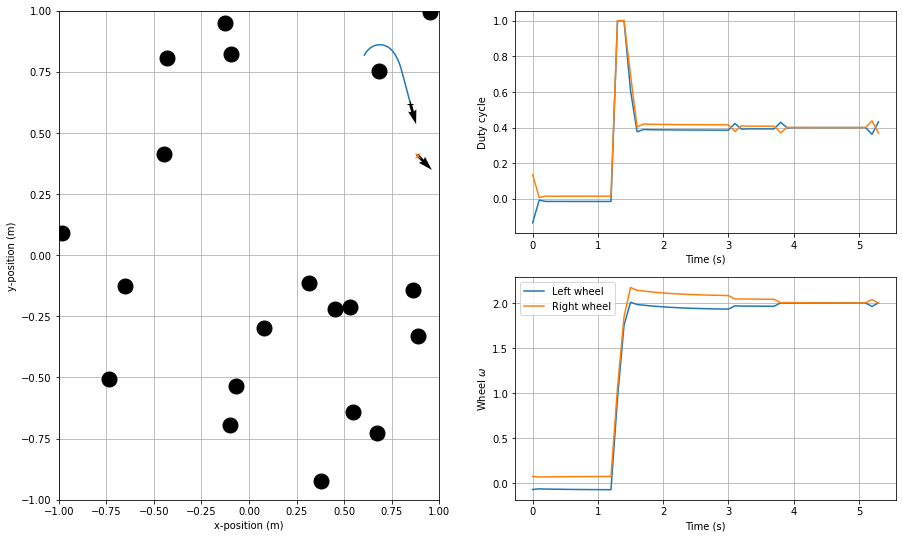

In [ ]:
plt.figure(figsize=(15,9))

poses = []
velocities = []
duty_cycle_commands = []

goal_x = 2*np.random.rand()-1
goal_y = 2*np.random.rand()-1
goal_th = 2*np.pi*np.random.rand()-np.pi

for i in range(200):

    # Example motion using controller 
    v,w = planner.plan(goal_x,goal_y,goal_th,robot.x,robot.y,robot.th)
    
    duty_cycle_l,duty_cycle_r = controller.drive(v,w,robot.wl,robot.wr)
    
    # Simulate robot motion - send duty cycle command to controller
    x,y,th = robot.pose_update(duty_cycle_l,duty_cycle_r)
    
    # Log data
    poses.append([x,y,th])
    duty_cycle_commands.append([duty_cycle_l,duty_cycle_r])
    velocities.append([robot.wl,robot.wr])
    
    # Plot robot data
    plt.clf()
    plt.subplot(1,2,1)
    plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
    plt.plot(x,y,'k',marker='+')
    plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
    plt.plot(goal_x,goal_y,'x',markersize=5)
    plt.quiver(goal_x,goal_y,0.1*np.cos(goal_th),0.1*np.sin(goal_th))
    
    plt.plot(obstacles[:,0],obstacles[:,1],'ko',markersize=15)
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel('x-position (m)')
    plt.ylabel('y-position (m)')
    plt.grid()
    
    plt.subplot(2,2,2)
    plt.plot(np.arange(i+1)*robot.dt,np.array(duty_cycle_commands))
    plt.xlabel('Time (s)')
    plt.ylabel('Duty cycle')
    plt.grid()
    
    plt.subplot(2,2,4)
    plt.plot(np.arange(i+1)*robot.dt,np.array(velocities))
    plt.xlabel('Time (s)')
    plt.ylabel('Wheel $\omega$')
    plt.legend(['Left wheel', 'Right wheel'])
    plt.grid()
    
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    

Cool, we now have all the pieces to navigate our robot. We just need something to set the goals now (sometimes the controller will fail to reach a goal, and you will need to select an alternative goal). 

Unfortunately, you'll find that the real world isn't perfect, and your position estimate of the robot will quickly go wrong, no matter how well you try to calibrate it. The wheels will slip, the encoders will mis-count, the model will be wrong and the controller errors will eventually accumulate. We call this odometry drift, and the only way around this is to perform simulataneous localisation and mapping or to update your position using an alternative measurement system. Still, the strategy above should take you pretty far.

If you're interested in learning more about mobile robot navigation, read the amazing textbook [Probabilistic Robotics](https://mitpress.mit.edu/books/probabilistic-robotics) by Thrun, Burgard and Fox.